Matrix factorization is a common tool used in recommendation systems. In particular, an algorithm known as ALS (alternating least squares) is very popular. I explore its mathematical foundations and provide an implementation in the programming language Python. I then test how well it performs on the MovieLens dataset.

The idea of matrix factorization starts with a user-item matrix $\mathbf{R_{m \times n}}$. Each row corresponds to one user and each column corresponds to one item. Each cell is the quantitative preference a user has for an item (e.g., a rating, number of times bought, etc.). In practice, most of these values are missing since a user only interacts with a small percentage of all items. The goal is then to predict these missing values. Then, we can sort these values per user in descending order and recommend the top $k$ items given the top $k$ items scores are above a given threshold (i.e., taking the top K doesn't make sense in an absolute sense if the filled-in values indicate the user has no preference for them)

The benefit of matrix factorization, is that if patterns exist in the $\mathbf{R_{m \times n}}$ matrix, we'd like to automatically learn these patterns. Suppose the matrix is approximated as:

$\mathbf{R_{m \times n}} \approx \mathbf{U_{m \times k}} {\mathbf{V_{n \times k}}}^{\text{T}}$.

In order to have the $\mathbf{V}$ matrix have its rows as items, just like how the rows of $\mathbf{U}$ will represent users, we need to take the transposition of $\mathbf{V}$ for the matrix multiplication to be valid.

What is the benefit of this factorization? Just as how neural networks can <i>learn</i> features given data, this matrix factorization will also learn features (as I will soon show).

We will see that each column in $\mathbf{V}$ represents an automatically learned feature. And each row in $\mathbf{U}$ is the linear strength of that feature for predicting a users preference to an item.

# Cost Function

So how do learn what the values of $\mathbf{U}$ and $\mathbf{V}$ are? We determine this via a cost function. A simple idea is, is to multiple the matrices $\mathbf{U}$ and $\mathbf{V}$ (starting from some initial values) and multiply them. Then, we can compare how close the values of $\mathbf{U}\mathbf{V}^{\text{T}}$ match the known $\mathbf{R_{m \times n}}$ matrix.  We compare using the squared error. We also introduce regularization to mitigate overfitting. Our cost function is the following:

$J(\mathbf{U}, \mathbf{V}) = \frac{1}{2}||\mathbf{R} - \mathbf{U}\mathbf{V}^{\text{T}}||^2 + \lambda_u ||\mathbf{U}||^2 +  \lambda_v ||\mathbf{V}||^2$

We can also write this out explicitly:

$J(\mathbf{U}, \mathbf{V}) = \sum_{i=1}^{m} \sum_{j=1}^{n} (\mathbf{R}_{ij} - \sum_{k=1}^{K} \mathbf{U}_{ik} \mathbf{V}_{jk})^{2} + \lambda_u \sum_{i=1}^{n} \sum_{k=1}^{K} \mathbf{U}_{ik}^2 + \lambda_v \sum_{j=1}^{n} \sum_{k=1}^{K} \mathbf{V}_{jk}^2$


In practice, not all entries in $\mathbf{R}$ are defined. So what do we do? This is equivalent to not having training examples, so we can just skip these entries. Later on our derivation, I show this is equivalent to setting the missing entries to 0.

The $\mathbf{U}_{ik} \mathbf{V}_{jk}$ term makes this function non-convex (i.e., no one global minimum). This is where a few assumptions are made to make the problem tractable. First, we hold $\mathbf{V}$ constant while optimizing over $\mathbf{U}$. Then, we hold $\mathbf{U}$ constant while optimizing over $\mathbf{V}$. We repeat this alternation until convergence. Hence, <i>alternating least squares</i>.

# U
To calculate $\mathbf{U}$, we first initialize the parameters in the matrix to small random values. We then treat $\mathbf{V}$ as fixed. Next, we break solving each $\mathbf{U}_i$ row into $m$ independent equations to solve.

Let's examine the ith row:

$J(\mathbf{U}_{i1}, \mathbf{U}_{i2}, ..., \mathbf{U}_{ik}; \mathbf{V}) = \sum_{j}^{n} (\mathbf{R}_{ij} - \sum_{k=1}^{K} \mathbf{U}_{ik} \mathbf{V}_{jk})^{2} + \lambda_u \sum_{k=1}^{K} \mathbf{U}_{ik}^2$

Let's recast the equation into its matrix form:

$J(\mathbf{U}_{i,*}) = (\mathbf{R}_{i,*} - \mathbf{U}_{i,*} \mathbf{V}^{\text{T}}) (\mathbf{R}_{i,*} - \mathbf{U}_{i,*} \mathbf{V}^{\text{T}})^{\text{T}}  + \lambda_u \mathbf{U}_{i,*} ({\mathbf{U}_{i,*}})^{\text{T}}$

Let's check our dimensions are valid:

$(1 \times 1) = (1 \times n - (1 \times k)(k \times n)) \;  (1 \times n - (1 \times k)(k \times n))^T + (1 \times k)(k \times 1)$


### Theoretical Insight

Now, some theoretical insight. Let's exploit a property of transposition (e.g., $(\mathbf{A}^{\text{T}}\mathbf{B})^{\text{T}} = \mathbf{B}^T\mathbf{A}$) to get:

$J(\mathbf{U}_{i,*}) = ((\mathbf{R}_{i,*})^{\text{T}} - \mathbf{V} (\mathbf{U}_{i,*})^{\text{T}})^{\text{T}} (\mathbf{R}_{i,*}^{\text{T}} - \mathbf{V} (\mathbf{U}_{i,*})^T)  + \lambda_u \mathbf{U}_{i,*} \mathbf{U}_{i,*}^{\text{T}}$

We can rename these variables and matrices. Let:

$\mathbf{y} \equiv (\mathbf{R}_{i,*})^T$

$\mathbf{X} \equiv \mathbf{V}$

$\beta \equiv (\mathbf{U}_{i,*})^T$

$\lambda \equiv \lambda_u$

This yields:

$J(\mathbf{\beta}) = (\mathbf{y} - \mathbf{X} \beta)^T (\mathbf{y} - \mathbf{X} \beta)  + \lambda \beta^T \beta$


This is the equation for Ridge regression (also known as Tikhonov regularization).


### X, y
In Ridge regression, $\mathbf{X}$ is the design matrix where each row is a training example and each column is a feature. Each row in $\mathbf{X}$ corresponds to an entry in the column vector $\mathbf{y}$. $\mathbf{y}$ is the response variable, that is, the outcome we are trying to predict given features.

For ALS, each outcome is the preference of a given user to a given item. And each row in $\mathbf{V}$ is a training example where each column is a feature. There are $k$ features. But wait, we never created the features! These features are in fact, learned from data. We call these features <i>latent</i> features for this reason. Latent means "hidden".

### $\beta$
And what is $\beta$? In linear regression, this is the linear relationship of each feature to the response variable $\mathbf{y}$. So the ith row of $\mathbf{U}$ represents the coefficients. If the number is 0 for example, there exists no linear relationship (this confirmation is decided by statistical significance).

## Ridge Regression

Our problem is now to solve the problem of Ridge regression. We want to minimize the following cost function:

$J(\beta) = (\mathbf{y} - \mathbf{X} \beta)^{\text{T}} (\mathbf{y} - \mathbf{X} \beta)  + \lambda \beta^{\text{T}} \beta$

Let's expand our cost function:

$J(\beta) = \mathbf{y}\mathbf{y}^{\text{T}} - \mathbf{y}^{\text{T}} \mathbf{X} \beta - (\mathbf{X} \beta)^{\text{T}} \mathbf{y} + (\mathbf{X}\beta)^{\text{T}} \mathbf{X} \beta + \lambda \beta^{\text{T}} \beta$

Note that $(\mathbf{X} \beta)^{\text{T}} \mathbf{y}$ is a scalar, and so a transpose of a scalar is itself. Thus $(\mathbf{X} \beta)^{\text{T}} \mathbf{y} = \mathbf{y}^{\text{T}} \mathbf{X} \beta$. We also simplify $(\mathbf{X}\beta)^T \mathbf{X} \beta$ to $\beta^{\text{T}} \mathbf{X}^T \mathbf{X} \beta$ This gives us the following:

$J(\beta) = \mathbf{y}\mathbf{y}^T - 2 \mathbf{y}^{\text{T}} \mathbf{X} \beta + \beta^{\text{T}} \mathbf{X}^{\text{T}} \mathbf{X} \beta + \lambda \beta^{\text{T}} \beta$

We now use matrix calculus to take the derivative with respect to the column vector $\beta$. We set this derivative equal to 0 (this locates a minimum, maximum, or an inflection point). This yields:


$\frac{\partial{J}}{{\partial \beta}} = -2\mathbf{y}^{\text{T}} \mathbf{X} + \frac{\partial{(\beta^{\text{T}} \mathbf{X}^{\text{T}} \mathbf{X} \beta)}}{{\partial \beta}} +  2 \lambda \beta^{\text{T}} = 0$


Note that $\mathbf{X}^{\text{T}} \mathbf{X}$ is a symmetric matrix. We can use the following property (see proposition 9 in https://atmos.washington.edu/~dennis/MatrixCalculus.pdf):

$\alpha = \mathbf{x}^{\text{T}} \textbf{A} \textbf{x} \implies \frac{\partial \alpha}{\partial \mathbf{x}} = 2 \textbf{x}^{\text{T}} \textbf{A}$

So now we get:

$-2y^{\text{T}} \mathbf{X} + 2\beta^{\text{T}} \mathbf{X}^{\text{T}} \mathbf{X} +  2 \lambda \beta^{\text{T}} = 0$

rearranging and dividing by $2$ throughout we get:

$y^{\text{T}} \mathbf{X} = \beta^{\text{T}} X^{\text{T}} \mathbf{X} + \lambda \beta^{\text{T}}$

Factoring out $\beta$:

$y^{\text{T}} \mathbf{X} = \beta^{\text{T}} (X^{\text{T}} \mathbf{X} + \lambda I)$

Taking inverse:

$y^{\text{T}} \mathbf{X} (\mathbf{X}^{\text{T}} \mathbf{X} + \lambda I)^{-1} = \beta^{\text{T}}$

Taking tranpose:

$\beta = (\mathbf{X}^{\text{T}} \mathbf{X} + \lambda I)^{-1} \mathbf{X}^{\text{T}} \mathbf{y} $

# Updating U Matrix

We now know the solution for:

$J(\beta) = (\mathbf{y} - \mathbf{X} \beta)^{\text{T}} (\mathbf{y} - \mathbf{X} \beta)  + \lambda \beta^{\text{T}} \beta$

is

$\beta = (\mathbf{X}^{\text{T}} \mathbf{X} + \lambda \mathbf{I})^{-1} \mathbf{X}^{\text{T}} \mathbf{y} $

Going back to our original equation

$J(\mathbf{U}_{i,*}) = ((\mathbf{R}_{i,*})^{\text{T}} - \mathbf{V} (\mathbf{U}_{i,*})^{\text{T}})^{\text{T}} ((\mathbf{R}_{i,*})^{\text{T}} - \mathbf{V} (\mathbf{U}_{i,*})^T)^{\text{T}}  + \lambda_u \mathbf{U}_{i,*} (\mathbf{U}_{i,*})^{\text{T}}$

We can just match up our vectors/matrices to get:

$(\mathbf{U}_{i,*})^{\text{T}} = (\mathbf{V}^{\text{T}} \mathbf{V} + \lambda_u \mathbf{I})^{-1} \mathbf{V}^{\text{T}} (\mathbf{R}_i)^T $

or traking tranpose:

$\mathbf{U}_{i,*} = \mathbf{R}_{i,*} \mathbf{V} (\mathbf{V}^{\text{T}} \mathbf{V} + \lambda_u \mathbf{I})^{-1}$


# Updating V Matrix

What about $\mathbf{V}_{j,*}$? The cost function for this in matrix form is:

$J(\mathbf{V}_{j,*}) = ((\mathbf{R}^{\text{T}})_{j,*} - \mathbf{V}_{j,*} \mathbf{U}^{\text{T}})(((\mathbf{R}^{\text{T}})_{j,*} - \mathbf{V}_{j,*} \mathbf{U}^{\text{T}})^{\text{T}} + \lambda_v \mathbf{V}_{j,*} (\mathbf{V}_{j,*})^{\text{T}}$

or

$J(\mathbf{V}_{j,*}) = (\mathbf{R}_{*,j} - \mathbf{U} (\mathbf{V}_{j,*})^{\text{T}})^{\text{T}} (\mathbf{R}_{*,j} - \mathbf{U} (\mathbf{V}_{j,*})^{\text{T}}) + \lambda_v \mathbf{V}_{j,*} (\mathbf{V}_{j,*})^{\text{T}}$

Let's check our dimensions are valid:

$(1 \times 1) = (m \times 1 - (m \times k)(k \times 1))^{\text{T}} \;  (m \times 1 - (m \times k)(1 \times k)^{\text{T}}) + (1 \times k)(k \times 1)$

Again, comparing to solution for Ridge regression we just match up terms:

$(\mathbf{V}_{j,*})^{\text{T}} = (\mathbf{U}^{\text{T}} \mathbf{U} + \lambda_v \mathbf{I})^{-1} \mathbf{U}^{\text{T}} \mathbf{R}_{*,j}$

or

$\mathbf{V}_{j,*} = ((\mathbf{R}^{\text{T}})_{j,*} \mathbf{U} (\mathbf{U}^{\text{T}} \mathbf{U} + \lambda_v I)^{-1}$

# Summary

For each ith row in $\mathbf{U}$:

$\mathbf{U}_{i,*} = \mathbf{R}_{i,*} \mathbf{V} (\mathbf{V}^{\text{T}} \mathbf{V} + \lambda_u \mathbf{I})^{-1}$

For each jth row in $\mathbf{V}$:

$\mathbf{V}_{j,*} = ((\mathbf{R}^{\text{T}})_{j,*} \mathbf{U} (\mathbf{U}^{\text{T}} \mathbf{U} + \lambda_v I)^{-1}$

For each ith row in $\mathbf{U}$:

$\mathbf{U}_{i,*} = \mathbf{R}_{i,*} \mathbf{V} (\mathbf{V}^{\text{T}} \mathbf{V} + \lambda_u \mathbf{I})^{-1}$
 
and so on ....

## Missing Entries

But what do we do when entries in $\mathbf{R}$ are undefined? Suppose we skip over these. Let's examine this term: $\mathbf{R}_{i,*} \mathbf{V}$. This computes $k$ dot products where each dot product is the ith row of $\mathbf{R}$ dotted with each column in $\mathbf{V}$. If we skip the missing entries in $\mathbf{R}$, this is equivalent to setting the missing entry in $\mathbf{R}$ to 0.

# Code
We've performed the mathematical analysis, now let's implement this using Python. First, we import all of the libraries we will need.

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from numpy.linalg import inv
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession

%matplotlib inline

The class below, implements the math we developed. We use sklearn's implementation of Ridge regression instead of rolling our own.

In [2]:
class CustomALS(object):
    """Predicts using ALS"""
    
    def __init__(self, k=20, n_iter=20, lambda_u=0.001,
                 lambda_v=0.001):
        
        self.k = k
        self.n_iter = 20
        self.lambda_u = lambda_u
        self.lambda_v = lambda_v
                                   
    def fit(self, R):
        self.R = R.copy()
        
        # Convert missing entries to 0
        self.R = np.nan_to_num(self.R)
            
        m, n = R.shape
  
        # Initialize
        self.U = np.random.normal(loc=0., scale=0.01, size=(m, self.k))
        self.V = np.random.normal(loc=0., scale=0.01, size=(n, self.k))

        I = np.eye(self.k)
        Iu = self.lambda_u * I
        Iv = self.lambda_v * I
        
        R_T = self.R.T
        
        model_u = Ridge(alpha=self.lambda_u,
                        fit_intercept=True,
                        normalize=True)
        
        model_v = Ridge(alpha=self.lambda_v,
                        fit_intercept=True,
                        normalize=True)
        
        for _ in range(self.n_iter):
            # NOTE: This can be parallelized
            for i in range(m):
                model_u.fit(X=self.V,
                            y=R_T[:,i])       
                self.U[i,:] = model_u.coef_
                
            # NOTE: This can be parallelized
            for j in range(n):
                model_v.fit(X=self.U,
                            y=R_T[j,:])        
                self.V[j,:] = model_v.coef_

        self.R_hat = self.U.dot(self.V.T)

For comparison, we also construct a version that uses Apache Spark's implementation.

In [3]:
spark = SparkSession.builder \
        .master("local") \
        .appName("test") \
        .getOrCreate()
        
class SparkALS(object):
    def __init__(self, k=20, n_iter=20, lambda_=0.001):   
        self.als = ALS(rank=k, maxIter=n_iter, regParam=lambda_)
    
    def fit(self, R):
        R = np.nan_to_num(R)
        ratings = []
        for i in range(R.shape[0]):
            for j in range(R.shape[1]):
                ratings.append((i, j, float(R[i,j])))

        df = spark.createDataFrame(ratings,
                                   ["user", "item", "rating"])
        
        model = self.als.fit(df)
        
        user_factors = model.userFactors.orderBy("id").collect()
        item_factors = model.itemFactors.orderBy("id").collect()
        
        self.U = np.array([f.features for f in user_factors])
        self.V = np.array([f.features for f in item_factors])
        self.R_hat = self.U.dot(self.V.T)

# MovieLens Dataset

So how well did we do? We leverage the MovieLens dataset test.

In [4]:
df_ratings = pd.read_csv('../ml-latest-small/ratings.csv')
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
R_df = df_ratings.pivot(index='userId',
                        columns='movieId',
                        values='rating'
                       ).fillna(np.nan)
R_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Decriptive Stats of Dataset

In [6]:
# Size
print('Size: {}'.format(R_df.shape))

# What is the density of this matrix?
num_entries = np.count_nonzero(~np.isnan(R_df))
N = R_df.shape[0] * R_df.shape[1]
density = round(num_entries / N, 2)
sparsity = 1. - density
print('Density: {}'.format(density))
print('Sparsity: {}'.format(sparsity))

# How many non-nans on average, per row?
c = np.count_nonzero(~np.isnan(R_df), axis=1)
print('# Ratings / User: {} +/- {}'.format(round(c.mean(), 2), round(c.std(), 2)))

Size: (671, 9066)
Density: 0.02
Sparsity: 0.98
# Ratings / User: 149.04 +/- 231.05


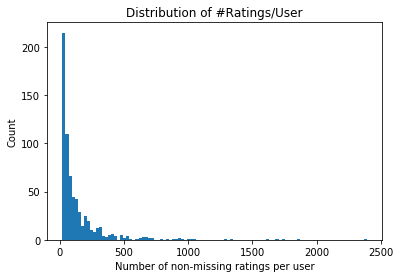

In [7]:
# Plot distribution
plt.hist(c, bins=100)
plt.title('Distribution of #Ratings/User')
plt.ylabel('Count')
plt.xlabel('Number of non-missing ratings per user')
plt.plot()
plt.show()

OK. Who the rated over 2,000 movies?

In [8]:
R_df[R_df.count(axis=1) > 2000]

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
547,3.5,NaN,NaN,NaN,NaN,2.5,2.0,NaN,NaN,NaN,...,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


Apparently user 547...

# Evaluation Metric

We need an evaluation metric to determine how well our algorithm performs. Classically in recommender systems, the RMSE (root mean squared error) is used. But we don't really care on predicting the absolute rating, but rather, did we rank the items correctly? A metric that captures this, is NDCG (normalized discounted cumulative gain)--developed by Kalervo Järvelin and Jaana Kekäläinen in the paper <b>IR evaluation methods for retrieving highly relevant documents</b>.

NDCG can be broken down into 4 distinct concepts:

<b>N</b> = <i>normalized</i>

<b>D</b> = discounted

<b>C</b> = cumulative

<b>G</b> = gain

Let's start with gain. Gain is the relevance value of the item. But now, suppose we look at the top $k$ items ranked. We can sum the gain of each item. This is the <i>cumulative</i> part. Thus:

$\text{CG} = \sum_i^k G_i$

But, suppose we were to shuffle the order of the items in the top $k$. The CG value is not affected since the gain is not a function of position. So what we do, is multiply by a discounting factor that <i>is</i> a function of position:

$D(i) = \frac{1}{log_2(i + 1)}$

We examine its multiplicative effect by plotting it for first 20 values:

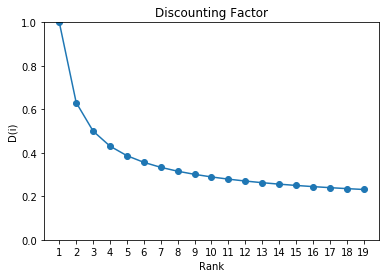

In [9]:
i = np.arange(1, 20)
plt.title("Discounting Factor")
plt.ylim([0., 1.])
plt.xticks(i)
plt.ylabel('D(i)')
plt.xlabel('Rank')
plt.plot(i, (lambda x: 1. / np.log2(x + 1))(i), marker='o')
plt.show()

Finally, the <i>normalized</i> part ensures that our metric is bounded between 0 and 1. To normalize, you just have to arrange the items in the top $k$ such that the max DCG value is obtained. But, this max DCG value considers all of the items, not just the ones filtered in top $k$. So as an example, suppose the true ordering of items rated by relevancy is:

[6, 4, 3, 2, 1]

But in our top k=3, we have:

[4, 3, 2]

But the true best top k=3 is actually:

[6, 4, 3]


So the DCG value of [6, 4, 3] is the max score. This is the constant we should divide by. We'll refer to this as IDCG (ideal discounted cumulative gain). So finally, our equation is as follows:


$NDCG = \frac{1}{IDCG} \sum_i^k \frac{G_i}{log_2(i + 1)}$

Now we can implement NDCG:

In [10]:
def ndcg_at_k(x, k):
    
    if k == 0:
        return .0
    elif k < 0:
        raise ValueError('k cannot be negative')
            
    # 1, 2, ..., k
    i = np.arange(1, k + 1)
    
    # Discount factor
    d = 1. / np.log2(i + 1)
    
    # Sorted for best possible scores
    x_best = np.sort(x)[::-1]
        
    # Compute normalization constant
    N = np.sum(d * x_best[:k])
    n = np.sum(d * x[:k])
    
    return n / N

OK, we are almost ready to test the models. Here's how this will work. We will run k fold cross validation on our dataset. By default, we will split our matrix into two parts. We will train on the first, then test on the second. Then train on the second, and test on the first. But what are we testing? In our test set, for a given user, we will perform stratified sampling. Our stratas are: ratings and missing ratings. From these stratas, we will allow the training to get access to half of each. Then during evaluation, we will select the test portions of the stratas, and examine how well we did via NDCG.



In [11]:
def cross_val_ndcg(model, X, n_splits=2):
    m, n = X.shape
    
    rows = list(range(m))
    
    # Row index
    I = np.array(range(n))
        
    # Now, split into K folds (by users)
    kf = KFold(n_splits=n_splits, shuffle=True)
    scores = []
    for train, test in kf.split(rows):
        
        # Assign test entries as undefined
        X_train = X.copy()
        X_test = X[test,:]
        
        user_indx = dict()
        
        # Prepare training set
        for i in test:            
            # Indices with non-nan
            pos_indx = I[~np.isnan(X[i,:])]
            neg_indx = I[np.isnan(X[i,:])]
            
            # Shuffle indices
            np.random.shuffle(pos_indx)
            np.random.shuffle(neg_indx)
                    
            pos_test, _ = np.array_split(pos_indx, 2)
            neg_test, _ = np.array_split(neg_indx, 2)
       
            test_indx = np.append(pos_test, neg_test)
            
            # "Hide" entries for this person
            X_train[i, pos_test] = np.nan
            
            # Remember what indices to
            # use during testing
            user_indx[i] = test_indx
        
        # Train
        model.fit(X_train)
        
        R_hat = model.R_hat
        
        for i in test:
            test_indx = user_indx[i]
            
            # Need to rank these
            # according to our algorithm
            values = X[i, test_indx]
            
            # Replace missing entries with 0
            I_ = np.array(range(len(values)))
            neg_indx = I_[np.isnan(values)]
            values[neg_indx] = 0.
            
            # These are the predicted values
            pred = R_hat[i, test_indx]
            
            # Get sorted index position
            sort_indx = np.argsort(pred)[::-1]
            
            values = values[sort_indx]
            
            # Now, order pred by holdout values
            ndcg = ndcg_at_k(values, k=20)
                    
            scores.append(ndcg)
            
    return scores

In [12]:
als_scores = cross_val_ndcg(CustomALS(), R_df.values, n_splits=2)

In [13]:
spark_als_scores = cross_val_ndcg(SparkALS(), R_df.values, n_splits=2)

In [16]:
scores = [{'scores': als_scores, 'name': 'als', 'color': 'blue'},
          {'scores': spark_als_scores, 'name': 'spark-als', 'color': 'red'}]

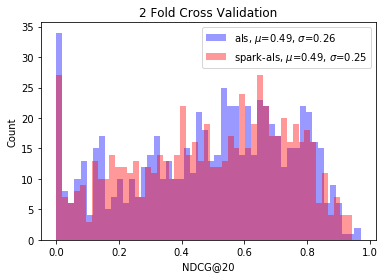

In [17]:
for v in scores:
    mu = round(np.mean(v['scores']),2)
    std = round(np.std(v['scores']),2)
    
    plt.hist(v['scores'], color=v['color'],
             bins=50, alpha=0.4,
             label='{}, $\mu$={}, $\sigma$={}'.format(v['name'], mu, std))

plt.ylabel('Count')
plt.xlabel('NDCG@20')
plt.title('2 Fold Cross Validation')
plt.legend(loc='upper right')

Above, we see the implmentations are similar. But this arises from the fact because we now <i>understand</i> how ALS works. Thanks for reading!